In [ ]:
# Прогнозирование аудитории пророком на данных из clickhouse
# https://facebook.github.io/prophet/

In [3]:
# Импортируем либы
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
from prophet import Prophet
import json

In [5]:
# read clickhouse connection info from file
connection_path = './creds/connection-student-rw-config.json'
with open(connection_path) as json_file:
    connection = json.load(json_file)

In [6]:
# Вкидываем данные (первый столбец - даты (ds), второй - уники (y))
query = """
SELECT 
    ds,
    uniqExact(DeviceID) AS y
FROM test.installs
WHERE 
        Source = 'Source_27'
    AND InstallCost = 0
GROUP BY CAST(InstallationDate AS Date)  AS ds
ORDER BY ds ASC
"""
df = ph.read_clickhouse(query, connection=connection)
df['ds'] = pd.to_datetime(df.ds)
df

,ds,y
0,2019-01-01,26243
1,2019-01-02,31303
2,2019-01-03,34017
3,2019-01-04,33807
4,2019-01-05,33925
...,...,...
272,2019-09-30,19028
273,2019-10-01,19176
274,2019-10-02,18926
275,2019-10-03,18373


In [7]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2015, 2016, 2017, 2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
100,2021-05-01,Праздник Весны и Труда
101,2021-05-09,День Победы
102,2021-06-12,День России
103,2021-11-04,День народного единства
104,2021-12-31,Новый год


In [8]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df[:-predictions]

In [9]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [10]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

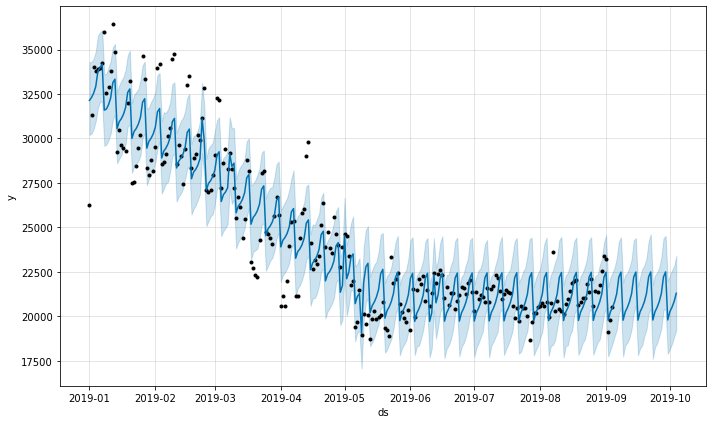

In [12]:
# Смотрим, что предсказалось
m.plot(forecast);

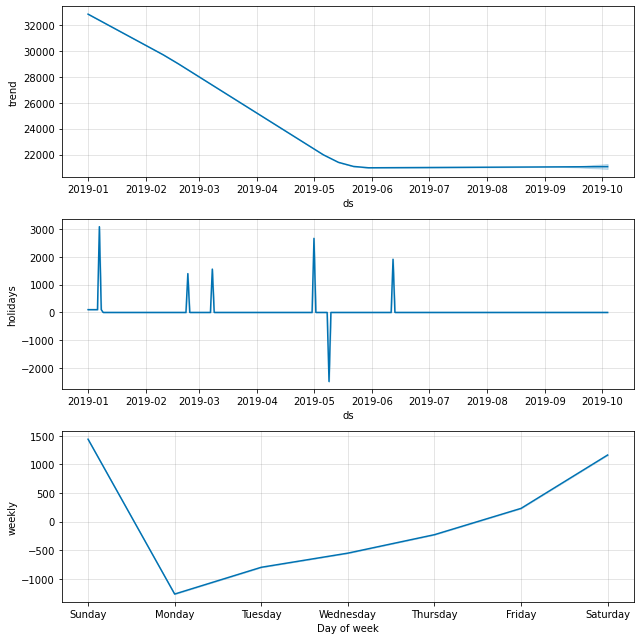

In [13]:
# Смотрим на сезонности
m.plot_components(forecast);

In [14]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [15]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  5.5405357603174945 %
MAE (средняя абсолютная ошибка) –  1075.0716735906249


In [16]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 90
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

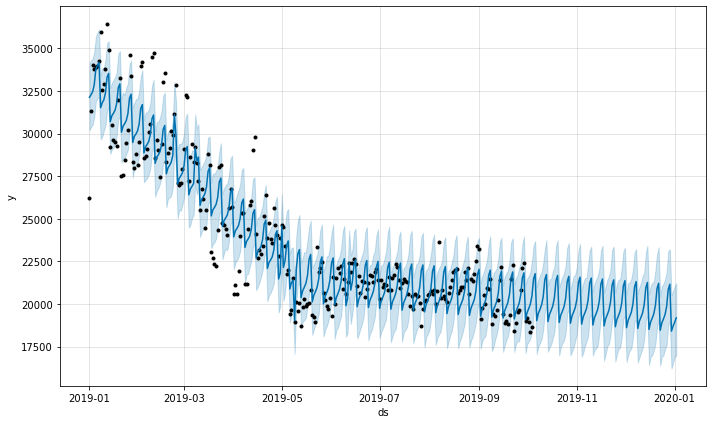

In [17]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

In [18]:
# Рисуем график с границами прогноза на полном периоде
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [ ]:
# Выгружаем прогноз в эксельку. Спрогнозированное значение лежит в столбце yhat
final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding="cp1251")